In [5]:
import numpy as np
import pandas as pd
import os
import pickle
import pretty_midi
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, concatenate, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [6]:
midi_folder_path = 'C:\\Users\\justin\\Documents\\final_year_project\\new_midi'
output_csv_path = 'C:\\Users\\justin\\Documents\\final_year_project\\new_dataset_with_genre_and_description.csv'

In [7]:
data = pd.read_csv(output_csv_path)
print(data.head())
midi_folder = midi_folder_path
midi_files = os.listdir(midi_folder)
print(f"Number of MIDI files: {len(midi_files)}")

                                    midi_name  \
0              .38 Special - Fantasy Girl.mid   
1        10,000_Maniacs - A_Campfire_Song.mid   
2  101_Strings - Theme_From_The_Godfather.mid   
3                10cc - Dreadlock_Holiday.mid   
4                   10cc - Im_Not_In_Love.mid   

                               processed_description genre  
0  fantasy girl special catchy pop tune blends sm...   pop  
1  maniacss campfire song soothing jazz number co...  jazz  
2  song theme godfather strings soothing jazz num...  jazz  
3  dreadlock holiday cc classic rock song blends ...  rock  
4  song love cc soothing jazz number featuring up...  jazz  
Number of MIDI files: 9711


In [8]:
def extract_piano_features(midi_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        piano_notes = []
        tempo_changes = []
        time_signatures = []
        pitch_bends = []
        control_changes = []
        key_changes = []

        # Extract piano notes
        for instrument in midi_data.instruments:
            if not instrument.is_drum and (instrument.program >= 0 and instrument.program <= 7):
                for note in instrument.notes:
                    start = note.start
                    end = note.end
                    pitch = note.pitch
                    velocity = note.velocity
                    duration = end - start
                    piano_notes.append([start, end, pitch, velocity, duration])

        # Extract tempo changes
        for change in midi_data.get_tempo_changes():
            tempo_changes.append(change)

        # Extract time signature changes
        for ts in midi_data.time_signature_changes:
            time_signatures.append([ts.time, ts.numerator, ts.denominator])

        # Extract pitch bend events
        for instrument in midi_data.instruments:
            if not instrument.is_drum and (instrument.program >= 0 and instrument.program <= 7):
                for pitch_bend in instrument.pitch_bends:
                    pitch_bends.append([pitch_bend.time, pitch_bend.pitch])

        # Extract control change events
        for instrument in midi_data.instruments:
            if not instrument.is_drum and (instrument.program >= 0 and instrument.program <= 7):
                for control_change in instrument.control_changes:
                    control_changes.append([control_change.time, control_change.number, control_change.value])

        # Extract key signature changes
        for ks in midi_data.key_signature_changes:
            key_changes.append([ks.time, ks.key_number])

        return {
            'piano_notes': piano_notes,
            'tempo_changes': tempo_changes,
            'time_signatures': time_signatures,
            'pitch_bends': pitch_bends,
            'control_changes': control_changes,
            'key_changes': key_changes
        }

    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return None
features_file = 'midi_features.pkl'

if os.path.exists(features_file):
    with open(features_file, 'rb') as f:
        midi_features_list = pickle.load(f)
    print("Loaded MIDI features from file.")
else:
    midi_features_list = []
    max_notes = 100  # Define maximum number of notes for padding

    for midi_name in tqdm(data['midi_name'], desc="Extracting MIDI features"):
        midi_path = os.path.join(midi_folder, midi_name)
        features = extract_piano_features(midi_path)
        if features:
            piano_notes = features['piano_notes']
            if len(piano_notes) > max_notes:
                piano_notes = piano_notes[:max_notes]
            else:
                piano_notes.extend([[0, 0, 0, 0, 0]] * (max_notes - len(piano_notes)))
            features['piano_notes'] = piano_notes
            midi_features_list.append(features)

    with tqdm(total=100, desc="Saving MIDI features") as pbar:
        with open(features_file, 'wb') as f:
            pickle.dump(midi_features_list, f)
        pbar.update(100)
    print("Extracted and saved MIDI features.")


Loaded MIDI features from file.


In [9]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

encoded_descriptions = []
for desc in tqdm(data['processed_description'], desc="Encoding descriptions"):
    encoded_descriptions.append(embedder.encode(desc))

data['encoded_description'] = encoded_descriptions
text_features = np.array(encoded_descriptions)


C:\Users\justin\anaconda3\envs\py310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Encoding descriptions: 100%|███████████████████████████████████████████████████████| 9711/9711 [02:06<00:00, 76.88it/s]


In [10]:
label_encoder = LabelEncoder()
data['genre_encoded'] = label_encoder.fit_transform(data['genre'])
genre_features = data['genre_encoded'].values

text_input_shape = text_features.shape[1]
midi_input_shape = 5 * 100  
genre_input_shape = 1  


In [11]:
# Text input branch
text_input = Input(shape=(text_input_shape,))
x1 = Dense(512, activation='relu')(text_input)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(256, activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)

# MIDI input branch
midi_input = Input(shape=(midi_input_shape, 1))
x2 = Conv1D(filters=128, kernel_size=3, activation='relu')(midi_input)
x2 = MaxPooling1D(pool_size=2)(x2)
x2 = BatchNormalization()(x2)
x2 = Bidirectional(LSTM(256, return_sequences=True))(x2)
x2 = BatchNormalization()(x2)
x2 = Bidirectional(LSTM(128))(x2)
x2 = BatchNormalization()(x2)
x2 = Dense(256, activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)

# Genre input branch
genre_input = Input(shape=(genre_input_shape,))
x3 = Dense(16, activation='relu')(genre_input)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.5)(x3)

# Combine branches
combined = concatenate([x1, x2, x3])
output = Dense(midi_input_shape, activation='linear')(combined)

model = Model(inputs=[text_input, midi_input, genre_input], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 498, 128)     512         ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 512)          197120      ['input_1[0][0]']                
                                                                                              

In [13]:
piano_notes_flattened = [np.array(f['piano_notes']).flatten() for f in midi_features_list]
y = np.array(piano_notes_flattened)

X_train_text, X_test_text, X_train_genre, X_test_genre, y_train, y_test = train_test_split(
    text_features, genre_features, y, test_size=0.2, random_state=42)

X_train_midi = np.expand_dims(y_train, axis=2)
X_test_midi = np.expand_dims(y_test, axis=2)

model.fit([X_train_text, X_train_midi, X_train_genre], y_train, epochs=100, batch_size=32, validation_split=0.2)
model.save('generative_midi_model.h5')


Epoch 1/100
195/195 [==============================] - 30s 152ms/step - loss: 1615.9342 - val_loss: 1050.0074
Epoch 2/100
195/195 [==============================] - 28s 145ms/step - loss: 640.3726 - val_loss: 411.0571
Epoch 3/100
195/195 [==============================] - 29s 148ms/step - loss: 389.3140 - val_loss: 372.7605
Epoch 4/100
195/195 [==============================] - 29s 149ms/step - loss: 352.6762 - val_loss: 180.0491
Epoch 5/100
195/195 [==============================] - 29s 148ms/step - loss: 309.2608 - val_loss: 353.4299
Epoch 6/100
195/195 [==============================] - 30s 154ms/step - loss: 294.7800 - val_loss: 189.6824
Epoch 7/100
195/195 [==============================] - 29s 148ms/step - loss: 284.2273 - val_loss: 196.4038
Epoch 8/100
195/195 [==============================] - 29s 146ms/step - loss: 275.9678 - val_loss: 142.0594
Epoch 9/100
195/195 [==============================] - 29s 148ms/step - loss: 264.1222 - val_loss: 125.6913
Epoch 10/100
195/195 [====

In [14]:
#with preprocessing

def generate_midi_from_description(model, embedder, description, genre, output_midi_path, tempo_scale=2.0):
    encoded_description = embedder.encode([description])
    
    encoded_genre = label_encoder.transform([genre])[0]
    
    predicted_midi_features = model.predict([encoded_description, np.zeros((1, midi_input_shape, 1)), np.array([encoded_genre])])

    predicted_notes = predicted_midi_features[0].reshape(-1, 5)  

    min_start_time = np.min(predicted_notes[:, 0])
    if min_start_time > 0:
        predicted_notes[:, 0] -= min_start_time
        predicted_notes[:, 1] -= min_start_time

    predicted_notes[:, 0] *= tempo_scale
    predicted_notes[:, 1] *= tempo_scale

    midi = pretty_midi.PrettyMIDI()

    instrument = pretty_midi.Instrument(program=0)

    for note in predicted_notes:
        start, end, pitch, velocity, _ = note  
        pitch = int(np.clip(pitch, 48, 84))  # Middle C range (C3 to C6)
        velocity = int(np.clip(velocity, 60, 127))  
        if start != 0 or end != 0:  #
            duration = end - start
            if duration < 0.1:
                end = start + 0.1  # minimum duration
                duration = 0.1
            elif duration > 2.0:
                end = start + 2.0  # maximum duration
                duration = 2.0

            midi_note = pretty_midi.Note(
                velocity=velocity, 
                pitch=pitch, 
                start=start, 
                end=end
            )
            instrument.notes.append(midi_note)
            print(f"Added note: start={start}, end={end}, pitch={pitch}, velocity={velocity}, duration={duration}")

    midi.instruments.append(instrument)

    midi.write(output_midi_path)

    print(f"Generated MIDI file saved to {output_midi_path}")

new_description = "fast and happy"
new_genre = "rock"  
generate_midi_from_description(model, embedder, new_description, new_genre, 'generated_midi_preprocessing.mid')


1/1 [==============================] - 1s 1s/step
Added note: start=7.562132358551025, end=7.691779136657715, pitch=48, velocity=60, duration=0.12964677810668945
Added note: start=6.356866836547852, end=6.456866836547851, pitch=48, velocity=60, duration=0.1
Added note: start=6.072422027587891, end=6.17242202758789, pitch=48, velocity=60, duration=0.1
Added note: start=6.208129405975342, end=6.308129405975341, pitch=48, velocity=60, duration=0.1
Added note: start=4.937708377838135, end=5.037708377838134, pitch=48, velocity=60, duration=0.1
Added note: start=5.120772361755371, end=5.220772361755371, pitch=48, velocity=60, duration=0.1
Added note: start=5.096987247467041, end=5.196987247467041, pitch=48, velocity=60, duration=0.1
Added note: start=5.508816242218018, end=5.608816242218017, pitch=48, velocity=60, duration=0.1
Added note: start=4.95857048034668, end=5.058570480346679, pitch=48, velocity=60, duration=0.1
Added note: start=4.980564117431641, end=5.08056411743164, pitch=48, vel

In [15]:
#without preprocessing

def generate_midi_from_description(model, embedder, description, genre, output_midi_path, tempo_scale=2.0, min_note_interval=0.1):
    encoded_description = embedder.encode([description])
    
    encoded_genre = label_encoder.transform([genre])[0]
    
    predicted_midi_features = model.predict([encoded_description, np.zeros((1, midi_input_shape, 1)), np.array([encoded_genre])])

    predicted_notes = predicted_midi_features[0].reshape(-1, 5)  # Assuming 5 features per note

    min_start_time = np.min(predicted_notes[:, 0])
    if min_start_time > 0:
        predicted_notes[:, 0] -= min_start_time
        predicted_notes[:, 1] -= min_start_time

    predicted_notes[:, 0] *= tempo_scale
    predicted_notes[:, 1] *= tempo_scale

    predicted_notes = predicted_notes[predicted_notes[:, 0].argsort()]

    predicted_notes[:, 1] = predicted_notes[:, 0] + np.clip(predicted_notes[:, 1] - predicted_notes[:, 0], 0.1, 2.0)

    midi = pretty_midi.PrettyMIDI()

    instrument = pretty_midi.Instrument(program=0)

    last_start_time = -min_note_interval  
    last_pitches = []  

    for note in predicted_notes:
        start, end, pitch, velocity, _ = note  
        pitch = int(np.clip(pitch, 48, 84)) 
        velocity = int(np.clip(velocity, 60, 127))  
        if start != 0 or end != 0:  
            if (start - last_start_time) > min_note_interval:
                duration = end - start
                if duration < 0.1:
                    end = start + 0.1  # minimum duration
                    duration = 0.1
                elif duration > 2.0:
                    end = start + 2.0  # maximum duration
                    duration = 2.0

                while pitch in last_pitches:
                    pitch = np.clip(pitch + np.random.randint(-12, 13), 48, 84)
                last_pitches.append(pitch)
                if len(last_pitches) > 10:
                    last_pitches.pop(0)

                midi_note = pretty_midi.Note(
                    velocity=velocity, 
                    pitch=pitch, 
                    start=start, 
                    end=end
                )
                instrument.notes.append(midi_note)
                last_start_time = start
                print(f"Added note: start={start}, end={end}, pitch={pitch}, velocity={velocity}, duration={duration}")

    midi.instruments.append(instrument)

    midi.write(output_midi_path)

    print(f"Generated MIDI file saved to {output_midi_path}")

new_description = "E minor slow and sad"
new_genre = "jazz"  
generate_midi_from_description(model, embedder, new_description, new_genre, 'generated_midiiiiii.mid')

1/1 [==============================] - 0s 67ms/step
Added note: start=0.4335094094276428, end=0.5335094332695007, pitch=48, velocity=60, duration=0.10000002384185791
Added note: start=0.755285382270813, end=0.8552854061126709, pitch=57, velocity=60, duration=0.10000002384185791
Added note: start=0.9234368205070496, end=1.0234368205070496, pitch=59, velocity=60, duration=0.1
Added note: start=1.082214117050171, end=1.1822141408920288, pitch=49, velocity=60, duration=0.10000002384185791
Added note: start=1.3268054723739624, end=1.4268054962158203, pitch=60, velocity=60, duration=0.10000002384185791
Added note: start=1.6189382076263428, end=1.7189382314682007, pitch=56, velocity=60, duration=0.10000002384185791
Added note: start=1.7308037281036377, end=1.8308037519454956, pitch=52, velocity=60, duration=0.10000002384185791
Added note: start=2.5393052101135254, end=2.6393052101135255, pitch=51, velocity=60, duration=0.1
Added note: start=2.6923704147338867, end=2.792370414733887, pitch=54,

61/61 [==============================] - 5s 66ms/step
Mean Squared Error: 109.35319357745158


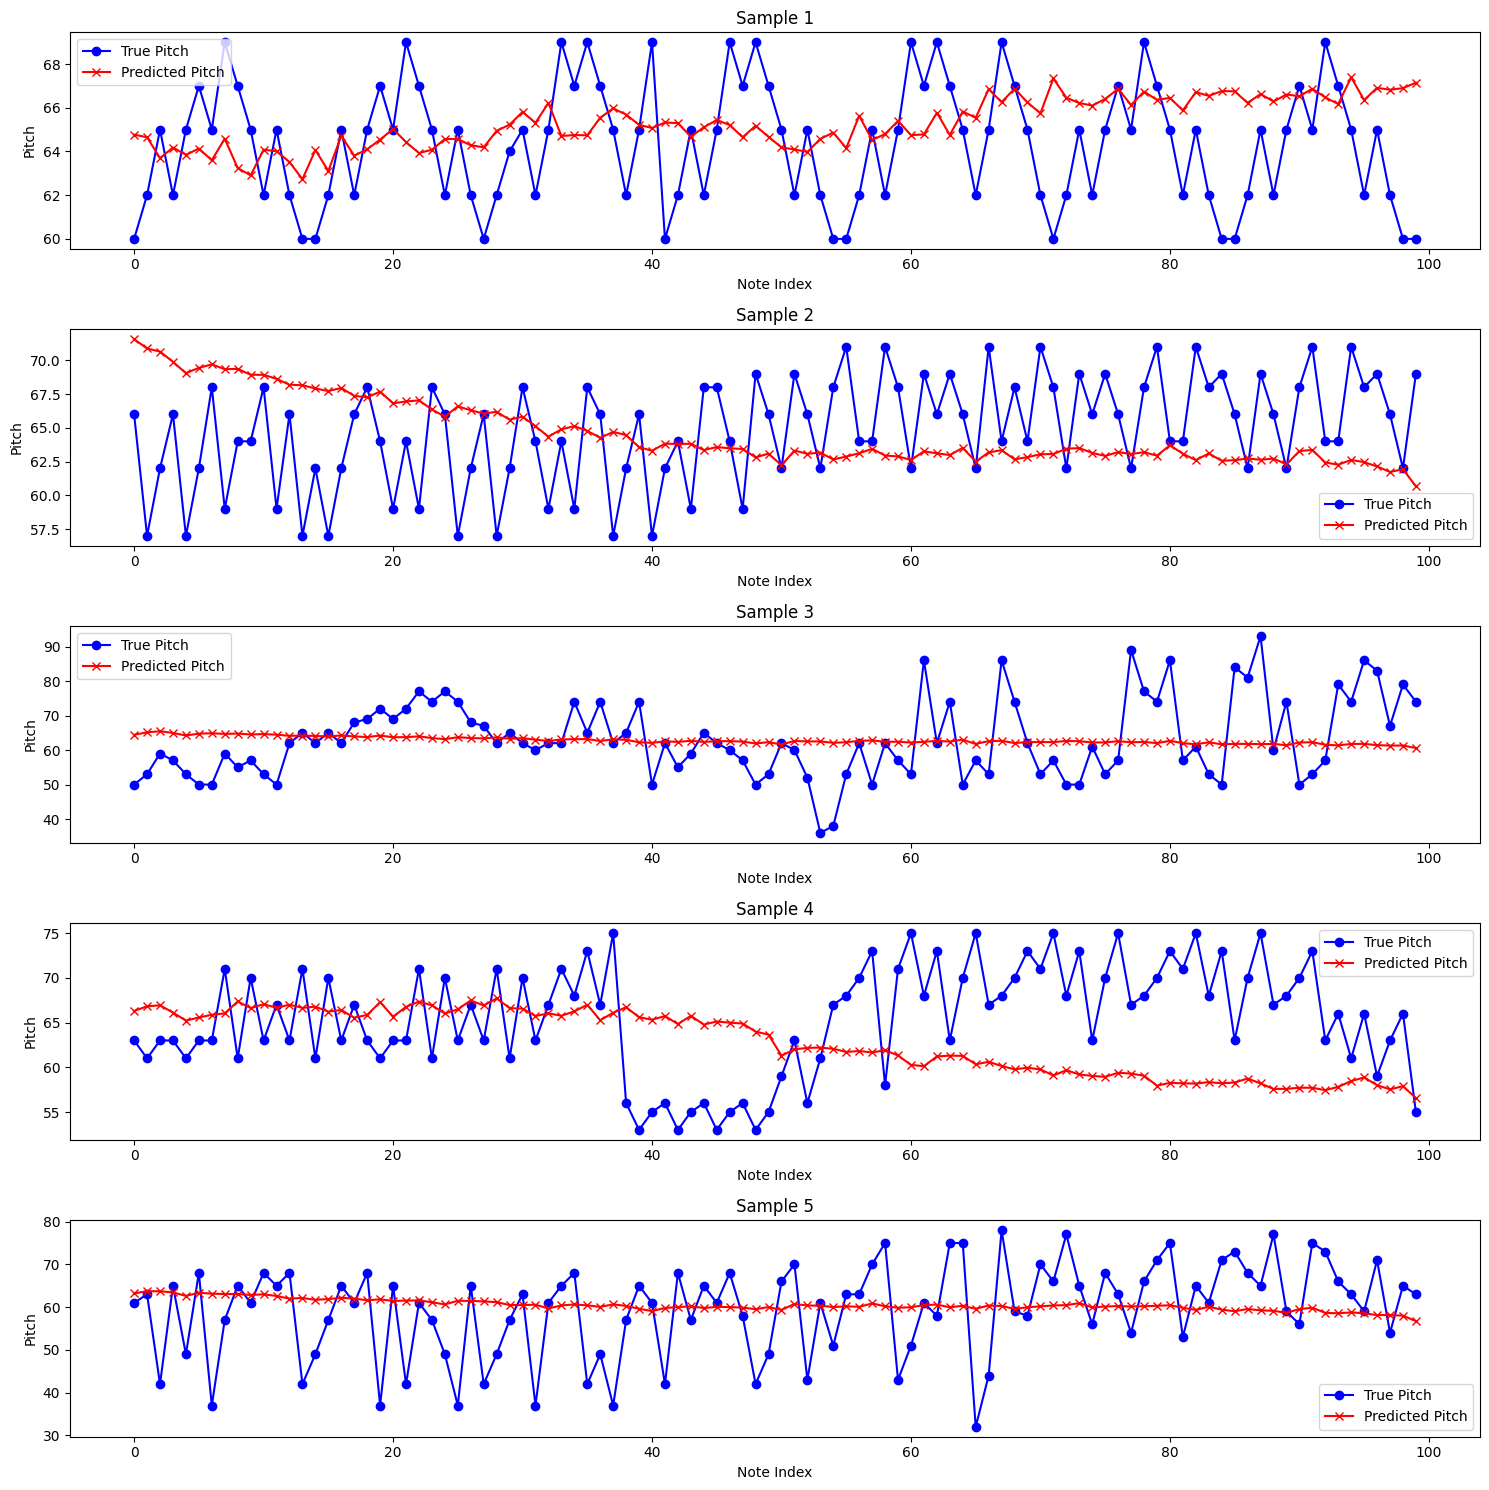

In [17]:
model = load_model('generative_midi_model.h5')

y_pred = model.predict([X_test_text, X_test_midi, X_test_genre])
y_pred_reshaped = y_pred.reshape(-1, 100, 5)
y_test_reshaped = y_test.reshape(-1, 100, 5)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

def plot_true_vs_predicted_pitch(y_true, y_pred, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))

    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        true_pitches = y_true[i][:, 2]
        pred_pitches = y_pred[i][:, 2]
        plt.plot(true_pitches, label='True Pitch', color='blue', marker='o')
        plt.plot(pred_pitches, label='Predicted Pitch', color='red', marker='x')
        plt.title(f'Sample {i + 1}')
        plt.xlabel('Note Index')
        plt.ylabel('Pitch')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_true_vs_predicted_pitch(y_test_reshaped, y_pred_reshaped, num_samples=5)
